In [64]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [66]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('C:\\Users\\bayra\\Desktop\\dataset')

In [67]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [68]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [69]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [70]:
def deriv_sigmoid(x):
    return x * (1 - x)

In [71]:
def RELU(x):
    return np.maximum(0, x)

In [72]:
def deriv_RELU(x):
    return x > 0

In [73]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}

    parameters["W1"] =  np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
    parameters["b1"] =  np.random.randn(layer_dims[1], 1)  * 0.01
    parameters["W2"] =  np.random.randn(layer_dims[2], layer_dims[1]) * 0.01 
    parameters["b2"] =  np.random.randn(layer_dims[2], 1) * 0.01

    return parameters

In [74]:
def linear_activation_forward(X,parameters):
    cache = {}
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = RELU(Z1)
    Z2 = np.dot(W2, A1) + b2
    AL = sigmoid(Z2)

    cache["Z1"] = Z1
    cache["A1"] = A1
    cache["Z2"] = Z2
    cache["AL"] = AL
    
    return AL, cache

In [75]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    
    return cost

In [76]:
def linear_activation_backward(parameters, cache, X, Y):
    grads = {}
    m = Y.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["AL"]
    Z1 = cache["Z1"]
    
    dZ2 = A2-Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * deriv_RELU(Z1)
    dW1 = 1 / m *np.dot(dZ1, X.T)
    db1 = 1 /m * np.sum(dZ1, axis = 1, keepdims=True)
    
    grads["dW1"] = dW1
    grads["db1"] = db1
    grads["dW2"] = dW2
    grads["db2"] = db2
    
    return grads

In [77]:
def update_parameters(parameters, grads, learning_rate):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    parameters["W1"] = W1 - dW1 * learning_rate
    parameters["b1"] = b1 - db1 * learning_rate
    parameters["W2"] = W2 - dW2 * learning_rate
    parameters["b2"] = b2 - db2 * learning_rate
    
    return parameters

In [78]:
def predict(X, Y, parameters):
    
    AL ,cache = linear_activation_forward(X,parameters)
    
    for i in range(AL.shape[1]):
        if AL[0,i] >= 0.5:
            AL[0, i] = 1
        else: 
            AL[0, i] = 0
    
    
    accurate_predictions = 0
    
    for i in range(AL.shape[1]):
        if AL[0, i] == Y[0, i]:
            accurate_predictions += 1
            
    accuracy = (accurate_predictions * 100)/Y.shape[1]
    
    return accuracy

In [79]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    
    (n_x, n_h, n_y) = layers_dims
    costs = []
    iterations = [i for i in range(3000) if i%100== 0]
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(num_iterations):
        
        AL, cache = linear_activation_forward(X,parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = linear_activation_backward(parameters, cache, X, Y)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
       
    return parameters, costs ,iterations

In [80]:
def main():
    
    parameters, costs, iterations = two_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000)
    
    accuracy = predict(test_x, test_y, parameters)
    print(f"Accuracy: {accuracy}%")
    
    plt.plot(iterations,costs)
    plt.xlabel('Iterations')
    plt.ylabel('Costs')
    plt.title('Cost Graph')
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6948558869316627
Cost after iteration 100: 0.6475543118707168
Cost after iteration 200: 0.6354635432195989
Cost after iteration 300: 0.6084781510864907
Cost after iteration 400: 0.5687536547908734
Cost after iteration 500: 0.5241385998103425
Cost after iteration 600: 0.4813053518578692
Cost after iteration 700: 0.43564949116183266
Cost after iteration 800: 0.3850252245643457
Cost after iteration 900: 0.407249438041115
Cost after iteration 1000: 0.35701586921864686
Cost after iteration 1100: 0.30658209947846765
Cost after iteration 1200: 0.26675711469903396
Cost after iteration 1300: 0.21728118634679475
Cost after iteration 1400: 0.25556810086614734
Cost after iteration 1500: 0.17685283394234955
Cost after iteration 1600: 0.14228868700024153
Cost after iteration 1700: 0.10398219194097094
Cost after iteration 1800: 0.09108319991279405
Cost after iteration 1900: 0.0744236675724208
Cost after iteration 2000: 0.06411714230540524
Cost after iteration 2100: 0.0560383

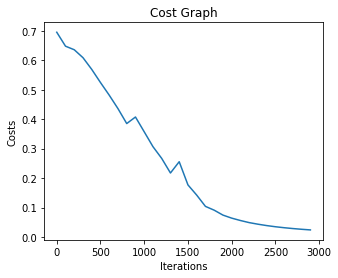

In [81]:
parameters = main()

In [82]:
    def test(X, Y, parameters, m):
        
        AL ,cache = linear_activation_forward(X,parameters)
        
        for i in range(AL.shape[1]):        # This part is only to see the predictions of the Neural Network
            if AL[0,i] >= 0.5:
                AL[0, i] = 1
            else: 
                AL[0, i] = 0

        print("Prediction: " + classes[int(AL[0,m])].decode("utf-8") )
        print("Label: " +classes[int(Y[0, m])].decode("utf-8"))
        plt.imshow(test_x_orig[m])
        

Prediction: cat
Label: cat


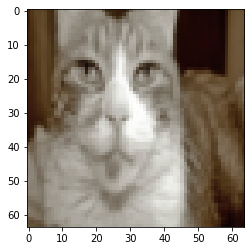

In [83]:
test(test_x,test_y,parameters,31)